# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 32

In [3]:
path = untar_data(URLs.PETS)/'images'

# Application -> Platform -> Infrastructure

The user facing application is a Jupyter notebook bundled up as part of Kubeflow framework for managing the lifecycle of machine learning pipelines that can be deployed on a Kubernetes cluster.

In this example, the underlying Kubernetes cluster has been configured to use `nvidia-docker` for running containerised workloads which can be targeted to use GPUs.

The machine learning framework that is used in this instance is called `fastai` which is a high level wrapper over `Pytorch`. It has built in support for callback functions which can be configured to inject custom code based on various events, e.g. `on_batch_end` at the end of every batch or `on_epoch_end` at the end of every epoch (an epoch is equivalent one exposure to every single example in the training dataset).

The `PostMetric` callback object below posts metrics to `Monasca` via a `statsd` agent running on an instance, in this case, the Kubernetes master node `openhpc-login-0`. The screenshot of Grafana dashboard shown below can be used to produce a visualisation as shown:

![Screenshot of Grafana dashboard](images/download_images/monasca-grafana-screenshot.png)

In [4]:
!pip install monasca-statsd -q

In [5]:
# Import the module.
from fastai.callbacks.loss_metrics import *
import monascastatsd as mstatsd

# Create the connection :-
# Ensure that if the host is not localhost, monasca-agent.target service is
# running with the following config inside `/etc/monasca/agent/agent.yaml`:
#
# Statsd:
#   monasca_statsd_port: 8125
#   non_local_traffic: true
#
conn = mstatsd.Connection(host='openhpc-login-0', port=8125)

# Create the client with optional dimensions
client = mstatsd.Client(connection=conn, dimensions={'env': 'fastai'})

# Create a gauge called fastai
gauge = client.get_gauge('fastai', dimensions={'env': 'fastai'})

class PostMetrics(LearnerCallback):

    def __init__(self):
        self.stop = False

    def on_batch_end(self, last_loss, **kwargs:Any)->None:
        if self.stop: return True #to skip validation after stopping during training
        # Record a gauge 50% of the time.
        gauge.send('trn_loss', float(last_loss), sample_rate=1.0)
        
    def on_epoch_end(self, last_loss, epoch, smooth_loss, last_metrics, **kwargs:Any):
        val_loss, error_rate = last_metrics
        gauge.send('val_loss', float(val_loss), sample_rate=1.0)
        gauge.send('error_rate', float(error_rate), sample_rate=1.0)        
        gauge.send('smooth_loss', float(smooth_loss), sample_rate=1.0)
        gauge.send('trn_loss', float(last_loss), sample_rate=1.0)
        gauge.send('epoch', int(epoch), sample_rate=1.0)        

## Data augmentation

In [6]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [7]:
doc(get_transforms)

In [8]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [9]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [10]:
data = get_data(224, bs, 'zeros')

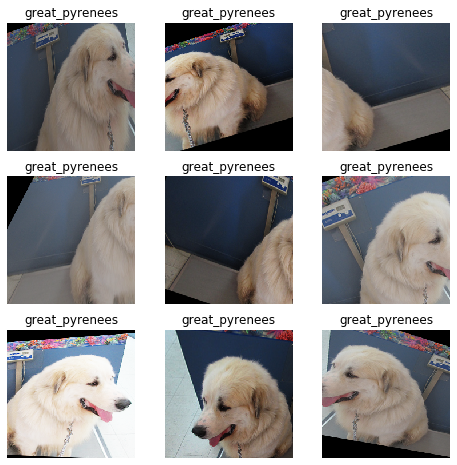

In [11]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [12]:
data = get_data(224,bs)

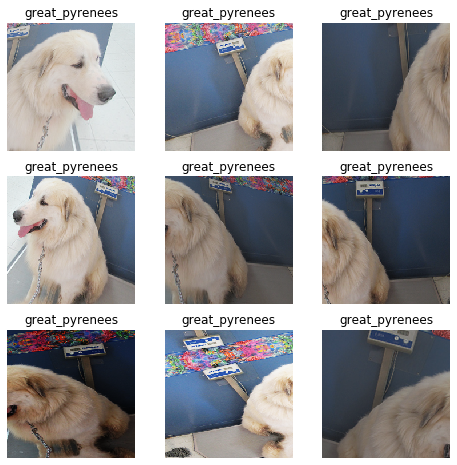

In [13]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [14]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True, callbacks=[PostMetrics()])

In [15]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

In [16]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-3), pct_start=0.8)

In [17]:
data = get_data(352,bs)
learn.data = data

In [18]:
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

In [19]:
learn.save('352')

## Convolution kernel

In [20]:
data = get_data(352,16)

In [22]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category yorkshire_terrier

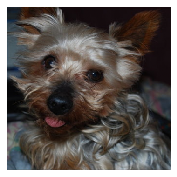

In [23]:
idx=40
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [24]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [25]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [26]:
k.shape

torch.Size([1, 3, 3, 3])

In [27]:
t = data.valid_ds[idx][0].data; t.shape

torch.Size([3, 352, 352])

In [28]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [29]:
edge = F.conv2d(t[None], k)

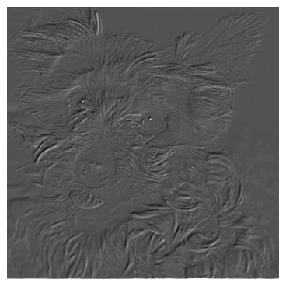

In [30]:
show_image(edge[0], figsize=(5,5));

In [31]:
data.c

37

In [32]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [33]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
______________________________________________________________

## Heatmap

In [34]:
m = learn.model.eval();

In [35]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [36]:
from fastai.callbacks.hooks import *

In [37]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [38]:
hook_a,hook_g = hooked_backward()

In [39]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [40]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [41]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

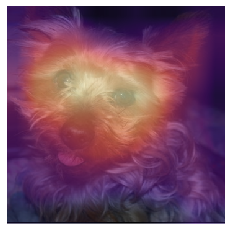

In [42]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [43]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [44]:
mult = (acts*grad_chan[...,None,None]).mean(0)

In [45]:
show_heatmap(mult)

In [46]:
fn = path/'../other/bulldog_maine.jpg' #Replace with your own image

In [47]:
fn = 'tank.jpg'

In [48]:
!curl https://nationalinterest.org/sites/default/files/styles/desktop__1486_x_614/public/main_images/tankbiathlon2016final-28.jpg?itok=UM1HBUl1 > {fn}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  221k  100  221k    0     0  1591k      0 --:--:-- --:--:-- --:--:-- 1591k


In [49]:
x = open_image(fn); x

In [50]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [51]:
hook_a,hook_g = hooked_backward()

In [52]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

In [53]:
show_heatmap(mult)

In [54]:
data.classes[0]

'Abyssinian'

In [55]:
hook_a,hook_g = hooked_backward(0)

In [56]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

In [57]:
show_heatmap(mult)

## fin